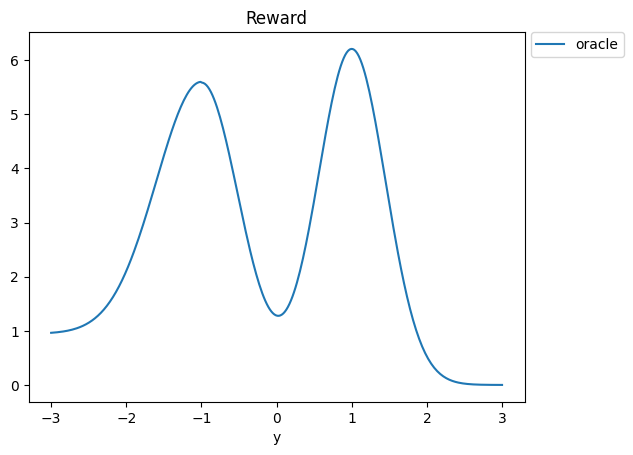

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch

BT_SAMPLE = False

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def reward_function(y):
    mean, std_dev = -1, 0.5
    component_1 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )
    mask = y > mean
    component_1_right = component_1 * mask

    std_dev = 0.6
    component_1 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    ) + 0.135
    component_1_left = component_1 * (1 - mask)

    mean, std_dev = 1, 0.45
    component_2 = (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )
    return 7*(component_1_left + component_1_right + component_2)


def policy(y):
    mean, std_dev = pi_ref_mu, pi_ref_std
    return (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(
        -0.5 * ((y - mean) / std_dev) ** 2
    )

n_sample_plot = 300
pi_ref_mu = -1
pi_ref_std = 0.35
y_plot = np.linspace(-3, 3, n_sample_plot)
r_plot = reward_function(y_plot)
pi_plot = policy(y_plot)

fig, ax = plt.subplots()
ax.plot(y_plot, r_plot, label="oracle")
# ax.plot(y_plot, pi_plot, label="pi_ref")
ax.set_xlabel("y")
ax.set_title("Reward")
ax.legend(ncol=1, bbox_to_anchor=(1.2, 1), borderaxespad=0)

Text(0.5, 0, "y'")

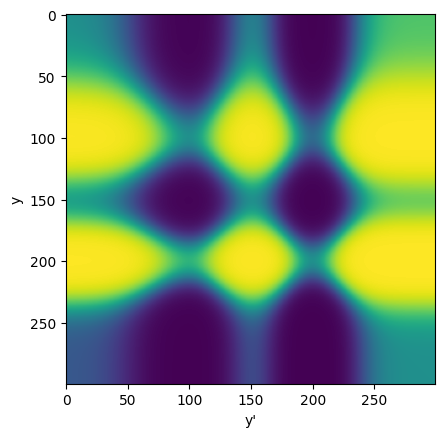

In [66]:
preference_landscape = np.zeros((n_sample_plot, n_sample_plot))
for i in range(n_sample_plot):
    for j in range(n_sample_plot):
        if BT_SAMPLE:
            z = np.random.binomial(1, p=sigmoid(reward_function(y_plot[i]) - reward_function(y_plot[j])))
            # z = reward_function(y_plot[i]) > reward_function(y_plot[j])
        else:
            # z = reward_function(y_plot[i]) > reward_function(y_plot[j])
            r1 = reward_function(y_plot[i])
            r2 = reward_function(y_plot[j])
            z = torch.tensor(r1 - r2).sigmoid().numpy()
        preference_landscape[i, j] = z

plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")

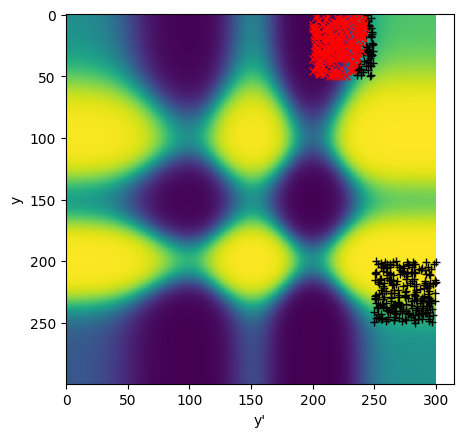

In [130]:
num_samples = 1000
# y_pairs = np.random.normal(pi_ref_mu, pi_ref_std, (num_samples, 2))
# y_pairs=np.random.multivariate_normal([1, 0], np.array([[0.1, 0.4], [0.1, 0.4]]), (num_samples,))
# y_pairs = np.random.uniform(-3, 3, (num_samples, 2))
# y_pairs = np.concatenate([np.stack([np.random.uniform(-1, 0, (250,)), np.random.uniform(1, 2, (250,))],-1), np.random.normal(pi_ref_mu, pi_ref_std, (250, 2))])
y_pairs = np.concatenate([np.stack([np.random.uniform(-3, -2, (250,)), np.random.uniform(1, 2, (250,))],-1),  np.stack([np.random.uniform(1, 2, (250,)), np.random.uniform(2, 3, (250,))],-1) ], 0)
# xs = np.random.uniform(-1.5, 1.5, (num_samples,))
# yx = 0 + np.random.rand(num_samples)
# y_pairs = np.stack([xs, yx], axis=-1)

if BT_SAMPLE:
    z_pairs = np.array([np.random.binomial(1, p=sigmoid(reward_function(y_pairs[i, 0]) - reward_function(y_pairs[i, 1]))) for i in range(len(y_pairs))])
else:
    z_pairs = reward_function(y_pairs[:, 0]) > reward_function(y_pairs[:, 1])
map_coord = lambda x: (x + 3) / 6 * n_sample_plot
plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")
for i, (y, yp) in enumerate(y_pairs):
    if z_pairs[i]:
        label = "+"
        color = "black"
    else:
        label = "x"
        color = "red"
    plt.plot(map_coord(yp), map_coord(y), label, color=color)

buffer size 500
9 {'train/rm/loss_rew': tensor(0.5416), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(-0.5144), 'train/rm/rejected_rewards': tensor(-0.8836), 'train/rm/lambda': 0.0}
19 {'train/rm/loss_rew': tensor(0.3476), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(-1.1044), 'train/rm/rejected_rewards': tensor(-2.0587), 'train/rm/lambda': 0.0}
29 {'train/rm/loss_rew': tensor(0.3072), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(-2.1532), 'train/rm/rejected_rewards': tensor(-3.4557), 'train/rm/lambda': 0.0}
39 {'train/rm/loss_rew': tensor(0.1658), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(-3.0961), 'train/rm/rejected_rewards': tensor(-5.1559), 'train/rm/lambda': 0.0}
49 {'train/rm/loss_rew': tensor(0.2454), 'train/rm/loss_reg': tensor(0.), 'train/rm/chosen_rewards': tensor(-4.4646), 'train/rm/rejected_rewards': tensor(-6.8586), 'train/rm/lambda': 0.0}
59 {'train/rm/loss_rew': tensor(0.1912), 'tra

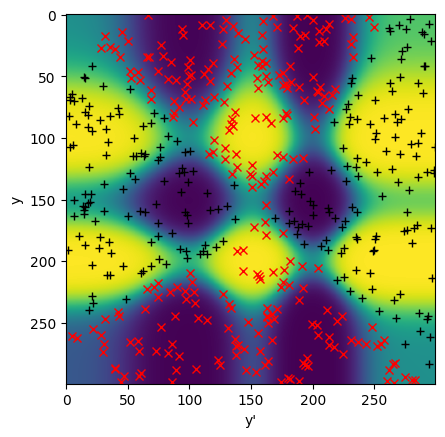

In [141]:
from ellm.rm import model as backbone
import torch
from torch import optim
from ml_collections import ConfigDict

X = torch.from_numpy(y_pairs).float()
Y = torch.from_numpy(z_pairs)[:, None].float()

def get_model_r(model, x):
    scores = model.model(x[None].repeat(model.model.num_ensemble, 1, 1))
    scores = scores.view(model.model.num_ensemble, -1)
    mean_scores = scores.mean(0)
    std_scores = scores.std(0)
    return mean_scores, std_scores, scores

def get_model_pred(model, x):
    x = x.view(-1, 1)

    # mean_scores = []
    # scores = []
    # for ndx in range(0, len(x), 512):
    #     batch_feat = x[ndx : min(ndx + 512, len(x))]
    #     _mean_score, _, _score = get_model_r(model, batch_feat)
    #     mean_scores.append(_mean_score)
    #     scores.append(_score)
    # mean_scores = torch.cat(mean_scores)
    # scores = torch.cat(scores)

    mean_scores, _, scores = get_model_r(model, x)
    mean_scores = mean_scores.view(-1, 2)
    scores = scores.view(model.model.num_ensemble, -1, 2)
    return (mean_scores[:, 0] - mean_scores[:, 1]).sigmoid(), scores

chosen_features = torch.where(Y == 1, X[:, :1], X[:, 1:])
rejected_features = torch.where(Y == 0, X[:, :1], X[:, 1:])
pair_features = torch.cat([chosen_features, rejected_features], dim=1).float()

model_cfg = ConfigDict(
    {
        "enn_max_try": 1,
        "num_ensemble": 20,
        "encoding_dim": 1,
        "rm_hidden_dim": 128,
        "rm_act_fn": "relu",
        "rm_lr": 1e-3,
        "rm_wd": 5e-5,
        "enn_lambda": 0,
        "exp_allow_second_best": False,
        "rm_sgd_steps": 1,
    }
)
model = backbone.EnnTSInfoMax(model_cfg)
from ellm.types import RewardData
from ellm.utils.buffer import UniformBuffer

batch = RewardData(
    pair_features=pair_features,
    loss_masks=torch.ones(len(pair_features)),
)
buffer = UniformBuffer(10000)
buffer.extend(batch)
print("buffer size", buffer.size)
buffer.total_num_queries = 32
model.train_bs = 32

num_epochs = 1000
mean_trajectory = []
std_trajectory = []

r_pred_mean, r_pred_std, _ = get_model_r(model, torch.from_numpy(y_plot).view(-1, 1).float())
r_pred_mean = r_pred_mean.squeeze().detach().numpy()
r_pred_std = r_pred_std.squeeze().detach().numpy()
mean_trajectory.append(r_pred_mean)
std_trajectory.append(r_pred_std)

for epoch in range(num_epochs):
    info = model.learn(buffer)
    if (epoch+1) % 10 == 0:
        print(epoch, info)
        r_pred_mean, r_pred_std, _ = get_model_r(model, torch.from_numpy(y_plot).view(-1, 1).float())
        r_pred_mean = r_pred_mean.squeeze().detach().numpy()
        r_pred_std = r_pred_std.squeeze().detach().numpy()
        mean_trajectory.append(r_pred_mean)
        std_trajectory.append(r_pred_std)

# Test
num_samples = 500
y_test = np.random.uniform(-3, 3, (num_samples, 2, 1))
y_input = torch.from_numpy(y_test).float()
z_pred = get_model_pred(model, y_input)[0] > 0.5
z_gt = reward_function(y_test[:, 0]) > reward_function(y_test[:, 1])
map_coord = lambda x: (x + 3) / 6 * n_sample_plot
plt.imshow(preference_landscape)
plt.ylabel("y")
plt.xlabel("y'")
for i, (y, yp) in enumerate(y_test):
    if z_pred[i]:
        label = "+"
        color = "black"
    else:
        label = "x"
        color = "red"
    plt.plot(map_coord(yp), map_coord(y), label, color=color)

print("accuracy:", ((z_pred.view(-1).numpy() == z_gt.reshape(-1))).mean())

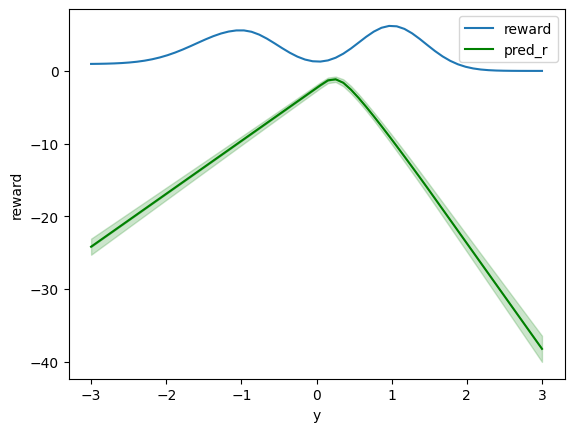

In [132]:
r_plot = reward_function(y_plot)
pi_plot = policy(y_plot)

j = -1
plt.plot(y_plot, r_plot, label="reward")
# plt.plot(y_plot, pi_plot, label="pi_ref")
plt.plot(y_plot, mean_trajectory[j], label="pred_r", color="green")
plt.fill_between(y_plot, mean_trajectory[j], mean_trajectory[j] + 2*std_trajectory[j], color="green", alpha=0.2)
plt.fill_between(y_plot, mean_trajectory[j] - 2* std_trajectory[j], mean_trajectory[j], color="green", alpha=0.2)
plt.xlabel("y")
plt.ylabel("reward")
plt.legend()

In [133]:
y_plot = np.linspace(-3, 3, 60)
xv, yv = np.meshgrid(y_plot, y_plot)
y_grid = np.stack([yv.reshape(-1), xv.reshape(-1)], axis=-1)[..., None]

y_input = torch.from_numpy(y_grid).float()
z_pred, std_scores = get_model_pred(model, y_input)
y_grid.shape

(3600, 2, 1)

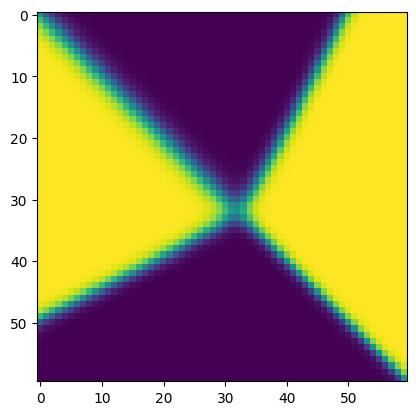

In [134]:
pred = z_pred.reshape(60, 60).detach().numpy()
plt.imshow(pred)

In [135]:
scores = std_scores.detach()
scores.shape

torch.Size([20, 3600, 2])

In [136]:
from ellm.rm import uncertainty
def get_image(scores, uct_fn, temperature=1.0, quantile=None):
    uct_fn = getattr(uncertainty, uct_fn)
    uct = uct_fn(scores[..., None], temperature)[:, 0, 1].numpy().reshape(60, 60)
    if quantile is not None:
        return uct < np.quantile(uct, quantile)
    return uct 

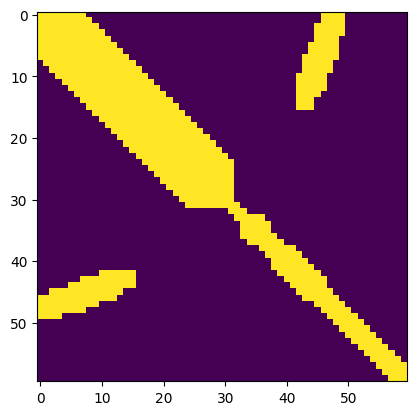

In [140]:
plt.imshow(get_image(scores, "logits_variance", 1, 0.2))

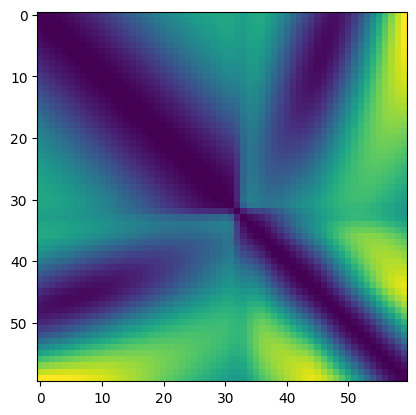

In [138]:
plt.imshow(get_image(scores, "kl_divergence", 10))

In [ ]:
plt.imshow(get_image(scores, "probabilities_variance", 20, 0.3))